In [289]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import time
import os
from skimage import data
from skimage import filters
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io, morphology
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.metrics import confusion_matrix

In [290]:
# path 

directory_path = 'IDRID_Segmentation/'
save_path = 'Exudates_result/'

if os.path.exists(save_path) is False:
    os.mkdir(save_path)

In [291]:
def getImage(img_num):
    if img_num<10:
        path = 'IDRiD_' + '00' +str(img_num) + '.jpg'
    else:
        path = 'IDRiD_' + '0' + str(img_num) + '.jpg'
    full_path = directory_path + path
    img = cv.imread(full_path, -1)
    return img     

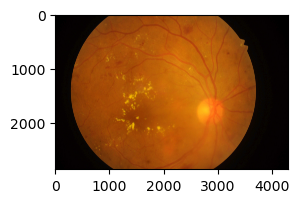

In [292]:
img_num = 1
img = getImage(img_num)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(img,cmap="gray")
plt.show()

In [293]:
def imgResize(img):
    h = img.shape[0]
    w = img.shape[1]
    perc = 500/w
    w1 = 500
    h1 = int(h*perc)
    img_rs = cv.resize(img,(w1,h1))
    return img_rs

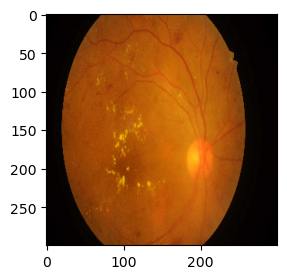

In [294]:
img_rs = resize(img)
plt.figure(figsize=(3,3))
plt.imshow(img_rs,cmap="gray")
plt.show()

# Detection of Large Exudates

Step 1: K-Means Clustering

In [295]:
def kMeansClustering(img, k, attempts, max_iter, acc):
    
    img_rsp = img.reshape((-1,3))

    img_rsp = img_rsp.astype('float32')


    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, acc)
    _, labels, (centers) = cv.kmeans(img_rsp, k, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)
    centers = centers.astype('uint8')

    labels = labels.flatten()
    seg_img = centers[labels.flatten()]
    seg_img = seg_img.reshape(img.shape)
    return seg_img

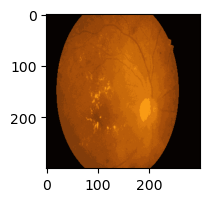

In [296]:
img_k = kMeansClustering(img_rs, 8, 5, 20, 0.69)
plt.figure(figsize=(2,2))
plt.imshow(img_k,cmap = 'gray')
plt.show()

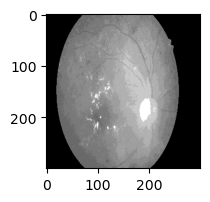

In [297]:
# convert image to gray scale
clus_seg = cv.cvtColor(img_k, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(2,2))
plt.imshow(clus_seg,cmap = 'gray')
plt.show()

Step 2: Extracting cluster with Highest Intensity

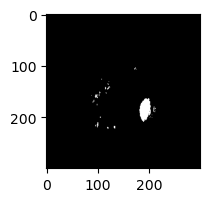

In [298]:
unique, counts = np.unique(clus_seg, return_counts=True)
_,kthm = cv.threshold(clus_seg, 
                      np.max(unique)-1, 
                      255, 
                      cv.THRESH_BINARY)
plt.figure(figsize=(2,2))
plt.imshow(kthm,cmap = 'gray')
plt.show()

# Detection of Small Exudates

Step 3: Canny Edge Detection

In [299]:
def cannyEdges(img, th1, th2):
    edges = cv.Canny(img, th1, th2)
    return edges

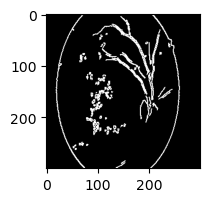

In [300]:
#sliptting channels
_, img_gc, _ = cv.split(img_rs)
edges = cannyEdges(img_gc, 70, 120)
img_cnt = cv.dilate(edges, 
                    cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
plt.figure(figsize=(2,2))
plt.imshow(img_cnt,cmap = 'gray')
plt.show()

Step 4: Countour Detection

In [301]:
def getContours(img, img_main, cnt_area):
    mask1 = np.ones(img.shape, dtype="uint8") * 0
    cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
    for i in cnts0:
        if cv.contourArea(i) <= cnt_area:
            cv.drawContours(mask1, [i], -1, 255, -1)
    mask1 = cv.bitwise_and(img_main, img_main, mask = mask1)
    return mask1

In [302]:
img_clean = getContours(img_cnt, img_gc, 15)
img_clean = cv.erode(img_clean, 
                     cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), 
                     iterations=1)
img_clean = cv.dilate(img_clean, 
                      cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), 
                      iterations = 2)
max_intsy = np.max(img_clean.flatten())
img_clean[img_clean>=max_intsy] = 255
img_clean[img_clean<max_intsy] = 0
_, img_clean = cv.threshold(img_clean, 173, 255, cv.THRESH_BINARY)

In [303]:
#Get result of Optic disc
def getODResult(img_num):
    if img_num < 10:
        path = 'maskOD_' + '00' + str(img_num) + '.jpg'
    else:
        path = 'maskOD_' + '0' + str(img_num) + '.jpg'
    full_path = 'OD_Result/' + path
    img_mark = cv.imread(full_path, -1)
    return img_mark

Step 5: Logical OR

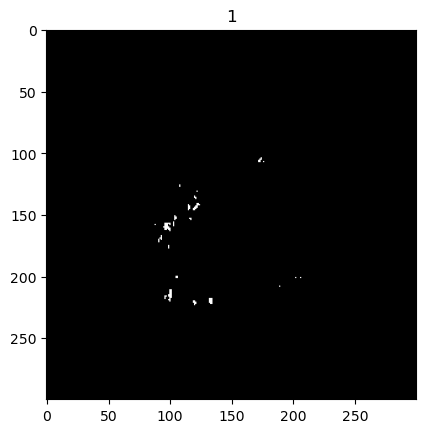

In [304]:
img_final = cv.bitwise_or(kthm, img_clean)

#Masking Optic Disc
img_mark = getODResult(img_num)
img_final[img_mark==0] = 0

plt.figure(img_num)
plt.title(img_num)
plt.imshow(img_final,cmap="gray")
plt.show()

# Entire dataset

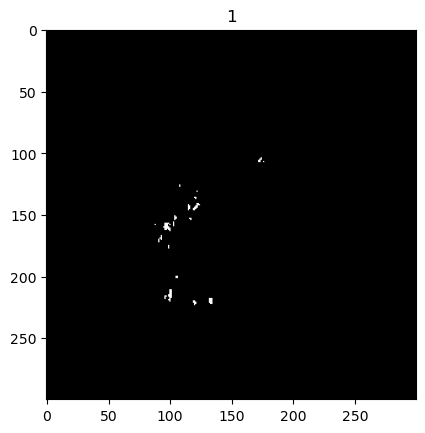

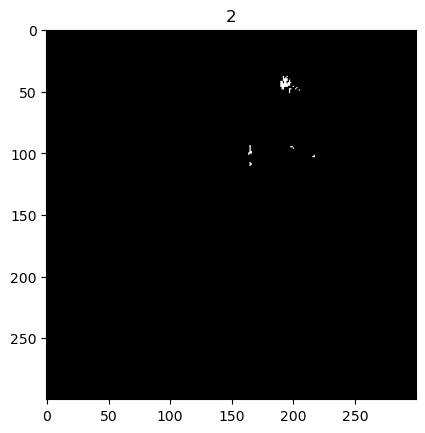

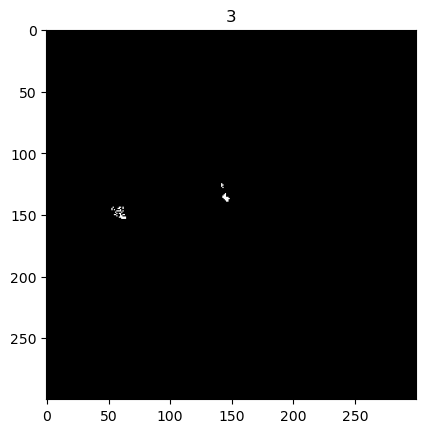

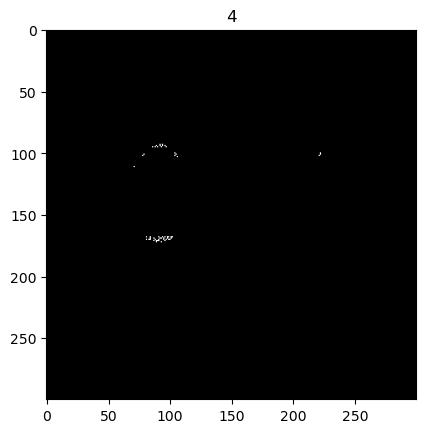

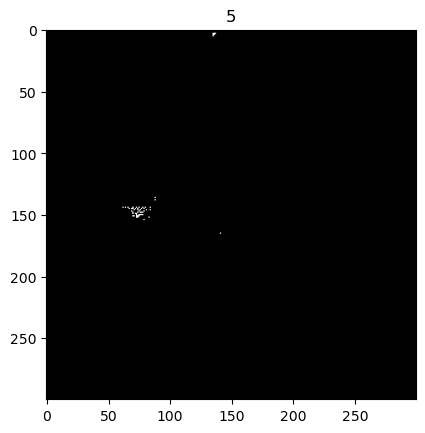

In [285]:
for img_num in range(1,82):
    img = getImage(img_num)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    img_rs = resize(img)
    
    img_k = kMeansClustering(img_rs, 8, 5, 20, 0.69)
    
    clus_seg = cv.cvtColor(img_k, cv.COLOR_BGR2GRAY)
    unique, counts = np.unique(clus_seg, return_counts=True)
    _,kthm = cv.threshold(clus_seg, 
                          np.max(unique)-1, 
                          255, 
                          cv.THRESH_BINARY)
    #sliptting channels
    _, img_gc, _ = cv.split(img_rs)
    edges = cannyEdges(img_gc, 70, 120)
    img_cnt = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
    img_clean = getContours(img_cnt, img_gc, 15)
    img_clean = cv.erode(img_clean, 
                         cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), 
                         iterations=1)
    img_clean = cv.dilate(img_clean, 
                          cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), 
                          iterations = 2)
    max_intsy = np.max(img_clean.flatten())
    img_clean[img_clean>=max_intsy] = 255
    img_clean[img_clean<max_intsy] = 0
    _, img_clean = cv.threshold(img_clean, 173, 255, cv.THRESH_BINARY)
    
    img_final = cv.bitwise_or(kthm, img_clean)

    #Masking Optic Disc
    img_mark = getODResult(img_num)
    img_final[img_mark==0] = 0
    
    if img_num < 10:
        path = 'e_' + '00' + str(img_num) + '.jpg'
    else:
        path = 'e_' + '0' + str(img_num) + '.jpg'
    img_path = save_path + path
    
    cv.imwrite(img_path,img_final)

    if img_num <= 5:
        plt.figure(img_num)
        plt.title(img_num)
        plt.imshow(img_final,cmap="gray")
        plt.show()